## Compare equatorial ocean metrics between obs and MOM6 run
1) Thermocline depth, gradient, strength 
2) Compare cold tongue strength 
3) EUC MOM6 vs obs, strength, depth, gradient


Obs data: # Use something more current WOA18

- /glade/p/cesm/omwg/obs_data/phc/PHC2_TEMP_tx0.66v1_34lev_ann_avg.nc 
- /glade/p/cesm/omwg/obs_data/phc/PHC2_SALT_tx0.66v1_34lev_ann_avg.nc 
- /glade/p/cesm/omwg/obs_data/johnson_pmel/meanfit_m.nc

#### Problems with this notebook: 
1) Actually the main problem is the use of zl and not e
2) The units for U say they are different, but they are not different by 100. What is the issue with the EUC? 
3) the unified plot is just a draft, should think about that some more, how to summarize the equatorial region? 

In [3]:
# Frank's notebooks in MOM6-modeloutputanalysis/EquatorialPacific
# use the h files 
# plot the model coordinates e

In [1]:
# Load required modules
import warnings
warnings.filterwarnings("ignore") # I don't want any warnings (: 

# the usual suspects
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import glob
import nc_time_axis # it says I need this to plot.. not sure 
import intake

# dask helpers 
from distributed import Client
from ncar_jobqueue import NCARCluster

# get mom6-tools 
import mom6_tools

In [2]:
cluster = NCARCluster(cores=2,
    processes=1,
    resource_spec='select=1:ncpus=2:mem=10GB',
)
cluster.adapt(minimum_jobs=2, maximum_jobs=8)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/deppenme/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/deppenme/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.60:33813,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/deppenme/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
# get the data from the coupled run 
dirname = "/glade/scratch/gmarques/bmom.e23.f09_t061_zstar_N65.nuopc.GM_tuning.002/run"
static = xr.open_dataset(*glob.glob(f"{dirname}/*static*.nc"))
ds_coupled = xr.open_mfdataset(
    sorted(glob.glob(f"{dirname}/*.mom6.h_*.nc")),
    coords="minimal",
    data_vars="minimal",
    compat="override",
    use_cftime=True,
    parallel=True,
)
ds_coupled.coords.update(static.drop("time"))

# time averaging
thetao = ds_coupled.thetao.mean('time')
so = ds_coupled.so.mean('time')
uo = ds_coupled.uo.mean('time')
eta = ds_coupled.e.mean('time')

j = np.abs(ds_coupled.yh).argmin().values

thetao_eq_mom = thetao.isel(yh=slice(j-5,j+5)).mean('yh');
salt_eq_mom = so.isel(yh=slice(j-5,j+5)).mean('yh');

In [4]:
catalog = intake.open_catalog("/glade/campaign/cgd/oce/catalogs/reference-datasets.yml")

phc = catalog["PHC2-tx0.66v1"].to_dask().rename({'X': 'xh','Y': 'yh', 'depth': 'z_l'})
johnson = catalog["eq-uvts-johnson"].to_dask()

In [17]:
thetao_obs = phc.TEMP
salt_obs = phc.SALT

# set coordinates to the same as the model's
thetao_obs['xh'] = ds_coupled.xh; thetao_obs['yh'] = ds_coupled.yh;
salt_obs['xh'] = ds_coupled.xh; salt_obs['yh'] = ds_coupled.yh;

# get the equatorial zone +-5 degrees  
thetao_eq_obs = thetao_obs.isel(yh=slice(j-5,j+5)).mean('yh');
salt_eq_obs = salt_obs.isel(yh=slice(j-5,j+5)).mean('yh')

In [5]:
y = ds_coupled.yh.values
zz = ds_coupled.z_i.values
x = ds_coupled.xh.values
[X, Z] = np.meshgrid(x, zz)
z = 0.5 * ( Z[:-1] + Z[1:])

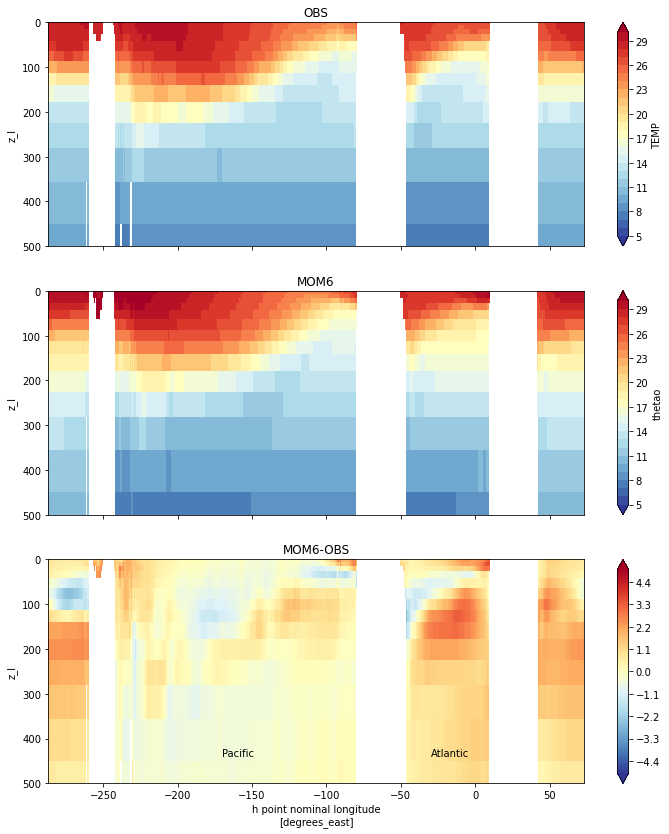

In [106]:
fig, ax = plt.subplots(3, 1, figsize=(12, 14), sharex=True, sharey=True)
thetao_eq_obs.plot(y='z_l', ylim=(500,0), levels=np.arange(5,31,1), cmap='RdYlBu_r', extend='both', ax=ax[0])
ax[0].set_title('OBS')
ax[0].set_xlabel('')

thetao_eq_mom.plot(y='z_l', ylim=(500,0), levels=np.arange(5,31,1), cmap='RdYlBu_r',  extend='both', ax=ax[1])
ax[1].set_title('MOM6')
ax[1].set_xlabel('')

(thetao_eq_mom-thetao_eq_obs).plot(y='z_l', ylim=(500,0), levels=np.arange(-5,5.1,.1), cmap='RdYlBu_r', extend='both', ax=ax[2])
ax[2].set_title('MOM6-OBS')

ax[2].text(-170, 440, 'Pacific')
ax[2].text(-30, 440, 'Atlantic')
plt.savefig('Eq_temp_MOM6_obs.png', bbox_inches='tight')

In [6]:
tc_eq_mom = thetao_eq_mom.differentiate('z_l').fillna(0).argmin(dim='z_l')
tc_eq_obs = thetao_eq_obs.differentiate('z_l').fillna(0).argmin(dim='z_l')

In [ ]:
# this is not going to work for hybrid -- the layers
# set up e_mid as the z coordinate then differentiate with respect to e_mid

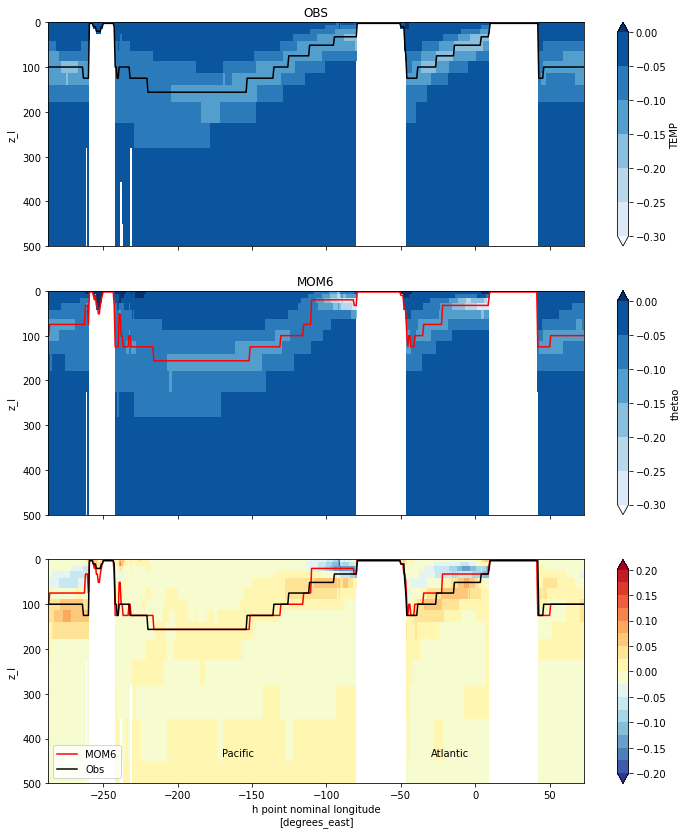

In [107]:
fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True, sharey=True)
thetao_eq_obs.differentiate('z_l').plot(y='z_l', ylim=(300,0), levels=np.arange(0,-0.35,-0.05), 
                                                                        cmap='Blues', extend='both', ax=ax[0])
thetao_eq_obs['z_l'][thetao_eq_obs.differentiate('z_l').fillna(0).argmin(dim='z_l')].plot(label='Obs', ax=ax[0], c='k')
ax[0].set_title('OBS')
ax[0].set_xlabel('')

thetao_eq_mom.differentiate('z_l').plot(y='z_l', ylim=(300,0), levels=np.arange(0,-0.35,-0.05),
                                                                    cmap='Blues', extend='both', ax=ax[1])
thetao_eq_mom['z_l'][thetao_eq_mom.differentiate('z_l').fillna(0).argmin(dim='z_l')].plot(label='MOM6', ax=ax[1], c='red')
ax[1].set_title('MOM6')
ax[1].set_xlabel('')

(thetao_eq_mom-thetao_eq_obs).differentiate('z_l').plot(y='z_l', ylim=(300,0), levels=np.arange(-0.2,0.225,0.025), 
                                                                                 cmap='RdYlBu_r', extend='both', ax=ax[2])
ax[2].set_title('MOM6-OBS')
thetao_eq_mom['z_l'][thetao_eq_mom.differentiate('z_l').fillna(0).argmin(dim='z_l')].plot(label='MOM6', ax=ax[2], c='red')
thetao_eq_obs['z_l'][thetao_eq_obs.differentiate('z_l').fillna(0).argmin(dim='z_l')].plot(label='Obs', ax=ax[2], c='k')
ax[2].legend()

ax[2].text(-170, 440, 'Pacific')
ax[2].text(-30, 440, 'Atlantic')
plt.savefig('Eq_diff_temp_MOM6_obs.png', bbox_inches='tight')

In [31]:
tc_depth_mom = thetao_eq_mom['z_l'][tc_eq_mom]
tc_depth_obs = thetao_eq_obs['z_l'][tc_eq_obs]

CPU times: user 11.8 s, sys: 480 ms, total: 12.3 s
Wall time: 27.1 s


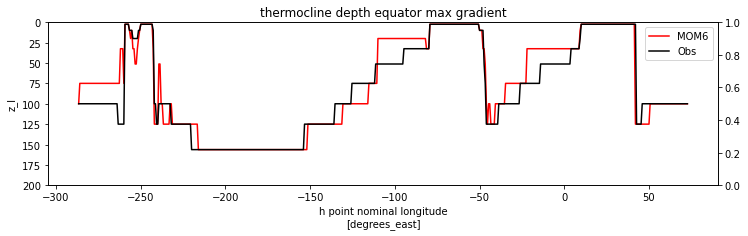

In [115]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(12, 3), sharex=True, sharey=True)

thetao_eq_mom['z_l'][tc_eq_mom].plot(label='MOM6', ax=ax, c='red')
thetao_eq_obs['z_l'][tc_eq_obs].plot(label='Obs', ax=ax, c='k', ylim=(200,0))
ax.legend()
ax.set_title('thermocline depth equator max gradient')

plt.savefig('thermocline_depth_mom6_obs_bias.png', bbox_inches='tight')

In [43]:
## get the gradient

xlonpacwest = -200
xlonpaceast = -100

xlonatlwest = -45
xlonatleast =  10

tc_gradient_pacific_obs = (tc_depth_obs.sel(xh=xlonpacwest, method='nearest').values 
                           -
                           tc_depth_obs.sel(xh=xlonpaceast, method='nearest').values)

tc_gradient_atlantic_obs= (tc_depth_obs.sel(xh=xlonatlwest, method='nearest').values
                           -
                           tc_depth_obs.sel(xh=xlonatleast, method='nearest').values)

tc_gradient_pacific_mom = (tc_depth_mom.sel(xh=xlonpacwest, method='nearest').values 
                           - 
                           tc_depth_mom.sel(xh=xlonpaceast, method='nearest').values)

tc_gradient_atlantic_mom= (tc_depth_mom.sel(xh=xlonatlwest, method='nearest').values
                           - 
                           tc_depth_mom.sel(xh=xlonatleast, method='nearest').values)


In [44]:
print('TC Pacific gradient obs:', tc_gradient_pacific_obs)
print('TC Pacific gradient mom:', tc_gradient_pacific_mom)

TC Pacific gradient obs: 105.0
TC Pacific gradient mom: 136.25


In [46]:
print('TC Atlantic gradient obs:', tc_gradient_atlantic_obs)
print('TC Atlantic gradient mom:', tc_gradient_atlantic_mom)

TC Atlantic gradient obs: 122.5
TC Atlantic gradient mom: 97.5


In [59]:
# get a handle for the strenth of the tc
mom_tc = thetao_eq_mom.differentiate('z_l').fillna(0).min(dim='z_l')
obs_tc = thetao_eq_obs.differentiate('z_l').fillna(0).min(dim='z_l')

tcstr_mom_pac = mom_tc.sel(xh=slice(xlonpacwest, xlonpaceast)).mean('xh').values
tcstr_obs_pac = obs_tc.sel(xh=slice(xlonpacwest, xlonpaceast)).mean('xh').values

tcstr_mom_atl = mom_tc.sel(xh=slice(xlonatlwest, xlonatleast)).mean('xh').values
tcstr_obs_atl = obs_tc.sel(xh=slice(xlonatlwest, xlonatleast)).mean('xh').values

In [61]:
print('ATL')
print('mom:', tcstr_mom_atl)
print('obs:', tcstr_obs_atl)

print('PAC')
print('mom:', tcstr_mom_pac)
print('obs:', tcstr_obs_pac)

ATL
mom: -0.15849766
obs: -0.1552407
PAC
mom: -0.107497044
obs: -0.12169789


# EUC
- depth
- strength
- gradient

In [70]:
u_eq_mom = uo.isel(yh=slice(j-5,j+5)).mean('yh');

In [8]:
johnson['XLON'] = (johnson.XLON-360)

CPU times: user 15.3 s, sys: 633 ms, total: 15.9 s
Wall time: 38.4 s


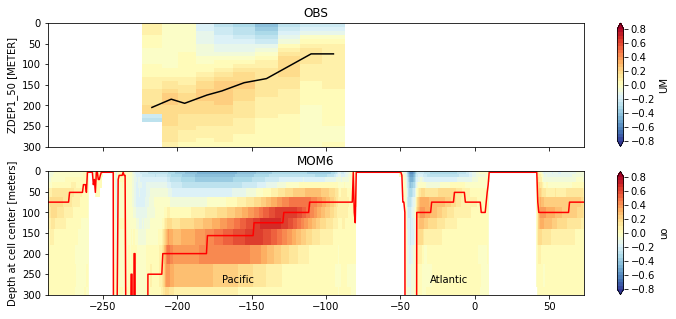

In [73]:
%%time
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True, sharey=True)
(johnson.UM).sel(YLAT11_101=slice(-5,5)).mean('YLAT11_101').plot(y='ZDEP1_50', ylim=(300,0), levels=np.arange(-0.8,0.85,0.05), 
                                                                        cmap='RdYlBu_r', extend='both', ax=ax[0])
johnson['ZDEP1_50'][johnson.UM.sel(YLAT11_101=slice(-5,5)).mean('YLAT11_101').argmax(dim='ZDEP1_50')].plot(label='Obs', ax=ax[0], c='k')
ax[0].set_title('OBS')
ax[0].set_xlabel('')

(u_eq_mom).plot(y='z_l', ylim=(300,0), levels=np.arange(-0.8,0.85,0.05), cmap='RdYlBu_r', extend='both', ax=ax[1])
u_eq_mom['z_l'][u_eq_mom.fillna(0).argmax(dim='z_l')].plot(label='MOM6', ax=ax[1], c='red')
ax[1].set_title('MOM6')
ax[1].set_xlabel('')

ax[1].text(-170, 270, 'Pacific')
ax[1].text(-30, 270, 'Atlantic')

plt.savefig('Eq_U_MOM6_obs.png', bbox_inches='tight')

CPU times: user 8.84 s, sys: 351 ms, total: 9.19 s
Wall time: 24.1 s


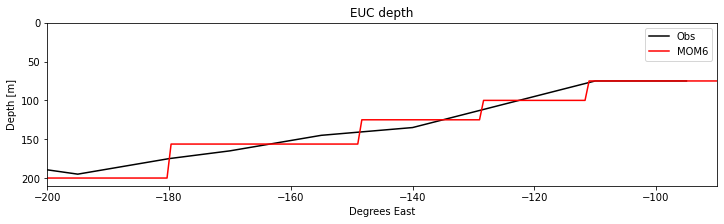

In [74]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(12, 3), sharex=True, sharey=True)

johnson['ZDEP1_50'][johnson.UM.sel(YLAT11_101=slice(-5,5)).mean('YLAT11_101').argmax(dim='ZDEP1_50')].plot(label='Obs', ax=ax, c='k')
u_eq_mom['z_l'][u_eq_mom.fillna(0).argmax(dim='z_l')].plot(label='MOM6', ax=ax, c='red')
ax.legend()
ax.set_xlim(-200,-90)
ax.set_title('EUC depth')
ax.set_ylim(210,0)
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Degrees East')
plt.savefig('EUC_johnson_mom6.png', bbox_inches='tight')

### Get the gradient of the EUC

In [79]:
# xlon1 = johnson['ZDEP1_50'][johnson.UM.sel(YLAT11_101=slice(-5,5)).mean('YLAT11_101').argmax(dim='ZDEP1_50')].XLON[0].values
# xlonlast = johnson['ZDEP1_50'][johnson.UM.sel(YLAT11_101=slice(-5,5)).mean('YLAT11_101').argmax(dim='ZDEP1_50')].XLON[-1].values
# it's better to specify longitudes
xlon1=-200
xlon2=-100

depth_euc_obs = johnson['ZDEP1_50'][johnson.UM.sel(YLAT11_101=slice(-5,5)).mean('YLAT11_101').argmax(dim='ZDEP1_50')]
depth_euc_mom = u_eq_mom['z_l'][u_eq_mom.fillna(0).argmax(dim='z_l')]

In [82]:
# get gradient: 
grad_euc_obs = (depth_euc_obs.sel(XLON=xlon1, method='nearest').values - depth_euc_obs.sel(XLON=xlonlast, method='nearest').values)
grad_euc_mom = (depth_euc_mom.sel(xq=xlon1, method='nearest').values - depth_euc_mom.sel(xq=xlonlast, method='nearest').values)
print('EUC gradient obs:', grad_euc_obs)
print('EUC gradient mom:', grad_euc_mom)

EUC gradient obs: 110.0
EUC gradient mom: 125.0


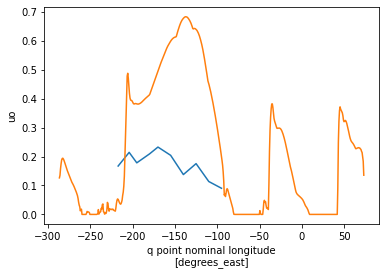

In [78]:
johnson.UM.sel(YLAT11_101=slice(-5,5)).mean('YLAT11_101').max(dim='ZDEP1_50').plot()
u_eq_mom.fillna(0).max(dim='z_l').plot()

In [83]:
# mean strength EUC
mean_euc_obs = johnson.UM.sel(YLAT11_101=slice(-5,5)).mean('YLAT11_101').max(dim='ZDEP1_50').sel(XLON=slice(xlon1,xlon2)).mean('XLON').values
mean_euc_mom = u_eq_mom.fillna(0).max(dim='z_l').sel(xq=slice(xlon1,xlon2)).mean('xq').values

#### it looks like the metrics are different but the values actually line up??

In [170]:
johnson.UM.attrs

{'long_name': 'U component of velocity',
 'history': 'From meanfit2',
 'units': 'cm/s'}

In [172]:
ds_coupled.uo.attrs

{'units': 'm s-1',
 'long_name': 'Sea Water X Velocity',
 'cell_methods': 'z_l:mean yh:mean xq:point time: mean',
 'time_avg_info': 'average_T1,average_T2,average_DT',
 'standard_name': 'sea_water_x_velocity',
 'interp_method': 'none'}

# Cold tongue


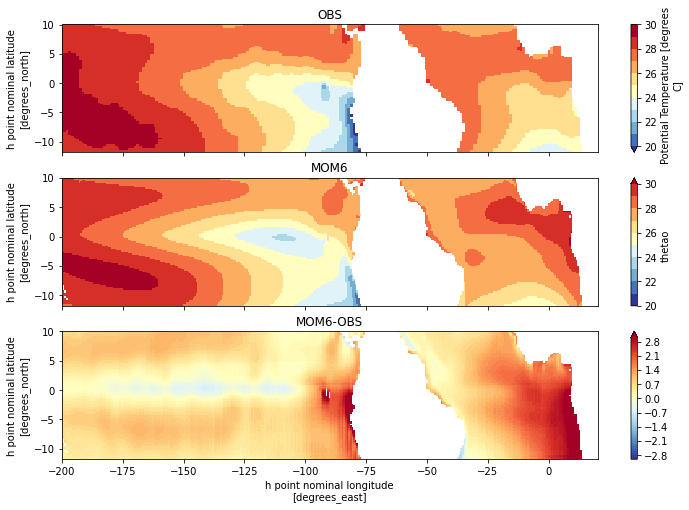

In [205]:
fig, ax = plt.subplots(3, 1, figsize=(12,8), sharex=True, sharey=True)
# look at the Benguela
thetao_obs.isel(z_l=0).sel(yh=slice(-12, 10)).plot(ax=ax[0], levels=np.arange(20,31,1), cmap='RdYlBu_r', xlim=(-200,20));
ax[0].set_xlabel('');
ax[0].set_title('OBS');

thetao.isel(z_l=0).sel(yh=slice(-12, 10)).plot(ax=ax[1], levels=np.arange(20,31,1), cmap='RdYlBu_r', xlim=(-200,20));
ax[1].set_title('MOM6');
ax[1].set_xlabel('');

(thetao-thetao_obs).isel(z_l=0).sel(yh=slice(-12, 10)).plot(ax=ax[2], levels=np.arange(-3,3.1,0.1), cmap='RdYlBu_r', xlim=(-200,20));
ax[2].set_title('MOM6-OBS');

plt.savefig('cold_tongues_obs_mom6.png', bbox_inches='tight');

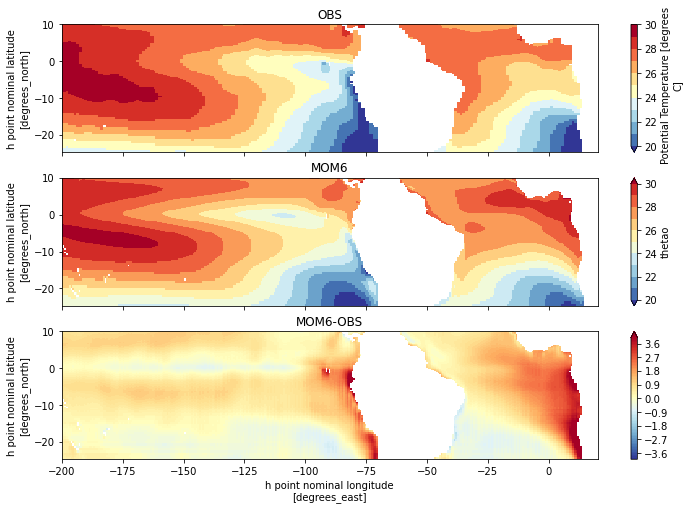

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(12,8), sharex=True, sharey=True)
# look at the Benguela
thetao_obs.isel(z_l=0).sel(yh=slice(-25, 10)).plot(ax=ax[0], levels=np.arange(20,31,1), cmap='RdYlBu_r', xlim=(-200,20));
ax[0].set_xlabel('');
ax[0].set_title('OBS');

thetao.isel(z_l=0).sel(yh=slice(-25, 10)).plot(ax=ax[1], levels=np.arange(20,31,1), cmap='RdYlBu_r', xlim=(-200,20));
ax[1].set_title('MOM6');
ax[1].set_xlabel('');

(thetao-thetao_obs).isel(z_l=0).sel(yh=slice(-25, 10)).plot(ax=ax[2], levels=np.arange(-4,4.1,0.1), cmap='RdYlBu_r', xlim=(-200,20));
ax[2].set_title('MOM6-OBS');

plt.savefig('cold_tongues_obs_mom6.png', bbox_inches='tight');

## Some things to look at: 
- winds? have a look at CESM2 and these runs ; Ghokan's paper? std diagnostics
- what about if you change the topography? 
- can we do high res atmosphere yet? ask Brian Medeiros and Julio (non leaky topo); Rich Neal add Cecile | send an email to Justin 
- stratocumulus
- ITCZ --> where is it? 
- currents?
- maybe SST variability?


In [147]:
# get location and temperature of cold tongue minimum in the Pacific
ct_loc_obs = thetao_obs.isel(z_l=0).sel(yh=slice(-2, 2), xh=slice(-200,-80)).argmin(dim=['xh','yh'])#['xh'].values
ct_min_obs = thetao_obs.isel(z_l=0).sel(yh=slice(-2, 2)).min(dim=['xh','yh']).values

ct_loc_mom = ds_coupled.thetao.mean('time').isel(z_l=0).sel(yh=slice(-2, 2), xh=slice(-200,-80)).argmin(dim=['xh','yh'])#['xh'].values
ct_min_mom = ds_coupled.thetao.mean('time').isel(z_l=0).sel(yh=slice(-2, 2)).min(dim=['xh','yh']).values

# This is currently useless in the Atlantic since there is no cold tongue in MOM... 
# talk to Justin. Something should really be done about this. 

## Unified plot 
show: 
- tc strength and gradient per basin
- euc strength and gradient

CPU times: user 19.5 s, sys: 759 ms, total: 20.2 s
Wall time: 53.4 s


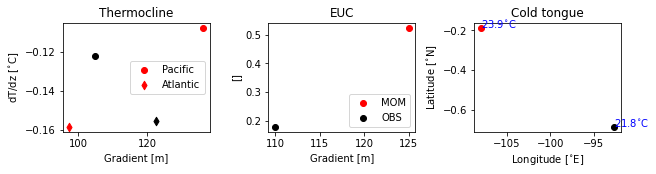

In [150]:
%%time

# come up with a clever figure that shows this
# summary of the equatorial state --> should have some more info, or maybe be more of a schematic? 
fig, ax = plt.subplots(1, 3, figsize=(10,2))

ax[0].scatter(tc_gradient_pacific_mom, tcstr_mom_pac, c='red', label='Pacific')
ax[0].scatter(tc_gradient_pacific_obs, tcstr_obs_pac, c='k')

ax[0].scatter(tc_gradient_atlantic_mom, tcstr_mom_atl, c='red', marker='d', label='Atlantic')
ax[0].scatter(tc_gradient_atlantic_obs, tcstr_obs_atl, c='k', marker='d')
ax[0].legend(loc='center right', frameon=True)


ax[1].scatter(grad_euc_mom, mean_euc_mom, c='red', label='MOM')
ax[1].scatter(grad_euc_obs, mean_euc_obs, c='k', label='OBS')
ax[1].legend(loc='lower right', frameon=True)
ax[0].set_title('Thermocline')
ax[1].set_title('EUC')

ax[0].set_xlabel('Gradient [m]')
ax[1].set_xlabel('Gradient [m]')

ax[0].set_ylabel(r'dT/dz [$^{\circ}$C]')
ax[1].set_ylabel(r'[]')

ax[2].scatter(thetao_obs.sel(yh=slice(-2, 2), xh=slice(-200,-80)).xh[ct_loc_obs['xh'].values], 
              thetao_obs.sel(yh=slice(-2, 2), xh=slice(-200,-80)).yh[ct_loc_obs['yh'].values], c='black')
ax[2].text(thetao_obs.sel(yh=slice(-2, 2), xh=slice(-200,-80)).xh[ct_loc_obs['xh'].values], 
              thetao_obs.sel(yh=slice(-2, 2), xh=slice(-200,-80)).yh[ct_loc_obs['yh'].values], 
          '{:3.1f}'.format(ct_min_obs)+r'$^{\circ}$C', c='blue')
ax[2].scatter(ds_coupled.thetao.sel(yh=slice(-2, 2), xh=slice(-200,-80)).xh[ct_loc_mom['xh'].values], 
              ds_coupled.thetao.sel(yh=slice(-2, 2), xh=slice(-200,-80)).yh[ct_loc_mom['yh'].values], c='red')
ax[2].text(ds_coupled.thetao.sel(yh=slice(-2, 2), xh=slice(-200,-80)).xh[ct_loc_mom['xh'].values], 
              ds_coupled.thetao.sel(yh=slice(-2, 2), xh=slice(-200,-80)).yh[ct_loc_mom['yh'].values], 
           '{:3.1f}'.format(ct_min_mom)+r'$^{\circ}$C', c='blue')

ax[2].set_ylabel(r'Latitude [$^{\circ}$N]')
ax[2].set_xlabel(r'Longitude [$^{\circ}$E]')

ax[2].set_title('Cold tongue Pacific')

plt.subplots_adjust(wspace=0.4)

plt.savefig('first_draft_of_unified_plot_EqBelt.png', bbox_inches='tight')